In [38]:
!pip install num2words
!pip install emoji

In [ ]:
import re
import nltk
import torch
import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

from nltk.corpus import stopwords

import matplotlib.pyplot as plt
from num2words import num2words
import emoji

nltk.download('stopwords')

MODEL_NAME = "CAMeL-Lab/bert-base-arabic-camelbert-da"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
df = pd.read_csv('ground_truth.csv')
df = df.drop(columns=['id'])

label_map = {"human": 0, "machine": 1}
df["label"] = df["label"].map(label_map)

stopwords_arabic = set(stopwords.words('arabic'))

# Arabic Text Cleaning Functions
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    return text

def remove_diacritics(text):
    arabic_diacritics = re.compile(r"[\u0617-\u061A\u064B-\u0652\u0670\u06D6-\u06ED]")
    return re.sub(arabic_diacritics, "", text)

def remove_tatweel(text):
    return re.sub(r'ـ+', '', text)

def remove_punctuation(text):
    arabic_punctuations = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”‘’،؛؟…«»"""
    return re.sub(f"[{re.escape(arabic_punctuations)}]", " ", text)

def normalize_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()

def remove_emojis(text):
    return emoji.replace_emoji(text, replace="")

def remove_urls_handles(text):
    pattern = re.compile(r'@\w+|https?://\S+|www\.\S+|#\w+|\S+@\S+|\d+')
    return pattern.sub(" ", text)

def numbers_to_arabic_words(text):
    def replace(match):
        num = int(match.group())
        return num2words(num, lang='ar')
    return re.sub(r'\d+', replace, text)


def clean_text(text):
    text = str(text).strip()

    text = remove_emojis(text)
    text = numbers_to_arabic_words(text)
    text = remove_urls_handles(text)

    text = normalize_arabic(text)
    text = remove_diacritics(text)
    text = remove_tatweel(text)
    text = remove_punctuation(text)

    text = normalize_whitespace(text)
    return text



cleaned_texts = df["content"].astype(str).apply(clean_text).tolist()
labels = torch.tensor(df['label'].values, dtype=torch.long)

# Tokenization
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
encodings = tokenizer(cleaned_texts, padding=True, truncation=True, max_length=128)

In [41]:
# Dataset
class ArabicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

dataset = ArabicDataset(encodings, labels)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
class BertClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModel.from_pretrained(MODEL_NAME)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 2)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        return self.classifier(cls_output)

model = BertClassifier().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

criterion = nn.CrossEntropyLoss()

for epoch in range(2):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        batch_labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        train_correct += (preds == batch_labels).sum().item()
        train_total += batch_labels.size(0)

    train_acc = train_correct / train_total

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")


/tmp/ipython-input-3034435254.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


Epoch 1 | Train Loss: 44.9346 | Train Acc: 0.8781
Epoch 2 | Train Loss: 10.0086 | Train Acc: 0.9804


In [42]:
model.eval()
preds = []
true_labels = []

with torch.no_grad():
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        batch_labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask)
        batch_preds = torch.argmax(outputs, dim=1)

        preds.extend(batch_preds.cpu().numpy())
        true_labels.extend(batch_labels.cpu().numpy())

label_map_r = {0: "human", 1: "machine"}
pred_labels = [label_map_r[p] for p in preds]

submission_df = pd.DataFrame({"label": pred_labels})

submission_df.to_csv("predictions.csv", index=False)
torch.save(model.state_dict(), "bert_classifier.pt")

/tmp/ipython-input-3034435254.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


Classification Report (TRAIN):
              precision    recall  f1-score   support

       human       1.00      0.96      0.98      2649
     machine       0.96      1.00      0.98      2649

    accuracy                           0.98      5298
   macro avg       0.98      0.98      0.98      5298
weighted avg       0.98      0.98      0.98      5298

Macro F1: 0.9797957635919793


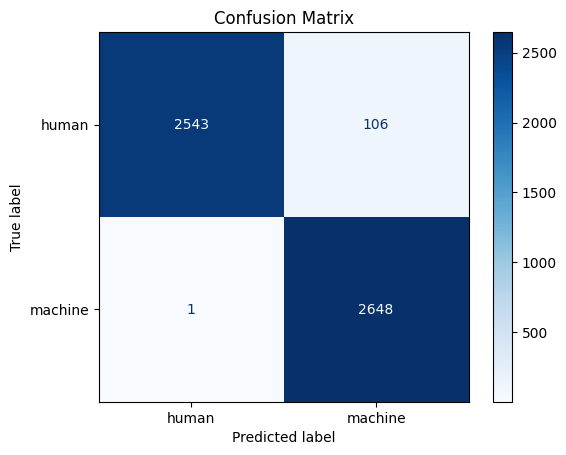

In [43]:
print("Classification Report (TRAIN):")
print(classification_report(
    true_labels,
    preds,
    target_names=["human", "machine"],
    digits=2
))

print("Macro F1:", f1_score(true_labels, preds, average='macro'))

cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["human", "machine"]
)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


In [45]:
# Testing on a different dataset

Classification Report:
              precision    recall  f1-score   support

       human      0.948     0.644     0.767      1000
     machine      0.731     0.965     0.832      1000

    accuracy                          0.804      2000
   macro avg      0.839     0.804     0.799      2000
weighted avg      0.839     0.804     0.799      2000

Macro F1: 0.799330708893781


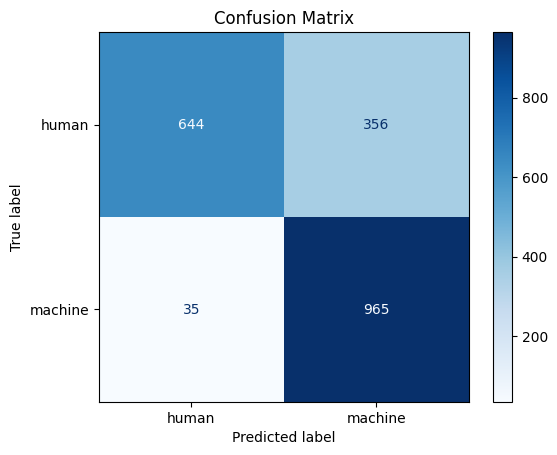

In [46]:
df = pd.read_parquet("by_polishing-00000-of-00001.parquet")

human_col = 'original_abstract'
ai_cols = [
    'allam_generated_abstract',
    'jais_generated_abstract',
    'llama_generated_abstract',
    'openai_generated_abstract'
]

def make_df(col, df, label):
    out = df[[col]].rename(columns={col: "text"})
    out["label"] = label
    return out

df_human = make_df(human_col, df, 0)
df_ai = make_df(ai_cols[0], df, 1)

df_test = pd.concat([df_human[:1000], df_ai[:1000]], ignore_index=True)
df_test["text"] = df_test["text"].astype(str).apply(clean_text)

encodings = tokenizer(
    df_test["text"].tolist(),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

model.eval()
preds = []

with torch.no_grad():
    for i in range(0, len(df_test), 32):
        input_ids = encodings["input_ids"][i:i+32].to(device)
        attention_mask = encodings["attention_mask"][i:i+32].to(device)

        outputs = model(input_ids, attention_mask)
        batch_preds = torch.argmax(outputs, dim=1)

        preds.extend(batch_preds.cpu().numpy())

# --- Evaluation ---
y_true = df_test["label"].values
y_pred = preds

print("Classification Report:")
print(classification_report(
    y_true,
    y_pred,
    target_names=["human", "machine"],
    digits=3
))

print("Macro F1:", f1_score(y_true, y_pred, average="macro"))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["human", "machine"]
)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


4 epochs

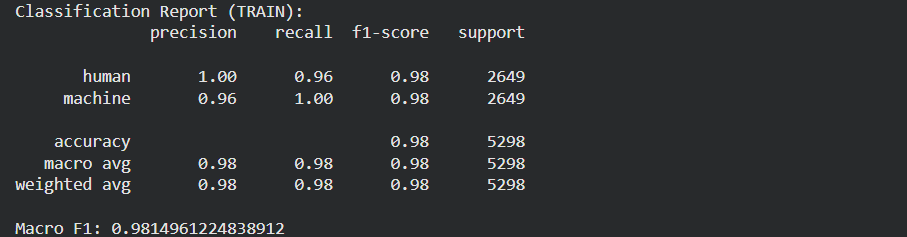

Test report:

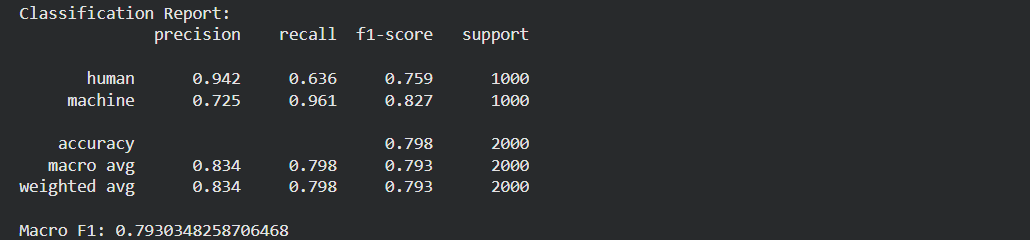

6 epochs

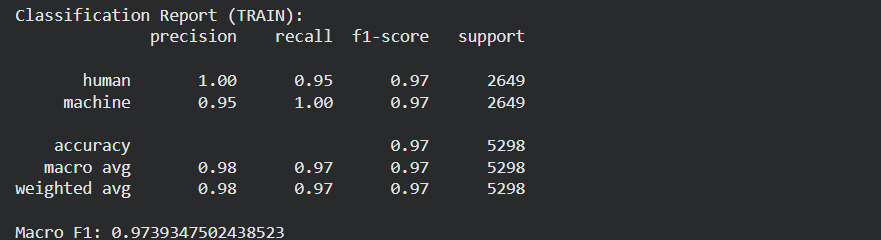

Test report:

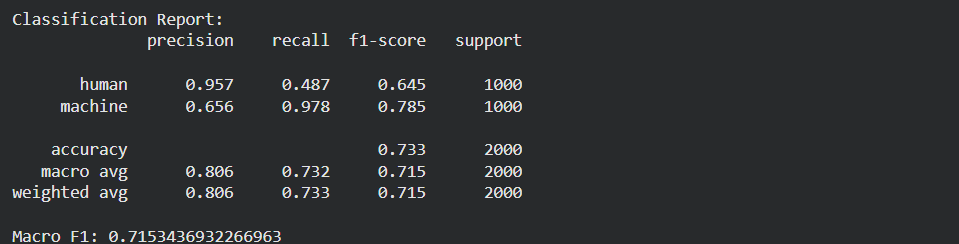